In [1]:
from matplotlib import pyplot as plt

import torch

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist
from pyro.infer.mcmc import HMC as HMC_Pyro

from hmc import HMC as HMC_Local
from sghmc import SGHMC as SGHMC_Local

In [2]:
pyro.clear_param_store()

#pyro.set_rng_seed(101)

# create some data with 6 observed heads and 4 observed tails
data = torch.ones(10)
data[0:6] = torch.zeros(6)
    
def model(data):
    alpha0 = torch.tensor(1.)
    beta0 = torch.tensor(1.)
    
    f = pyro.sample("fairness", dist.Beta(alpha0, beta0))
    
    for i in pyro.plate("data_loop", len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
      
    '''def model(data):
    loc = pyro.sample("loc", dist.Normal(5,10))
    return pyro.sample("out", dist.Normal(loc, 1), obs=data)'''

    '''def sg_model(mini_batch):
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    
    for i in pyro.plate("data_loop", len(mini_batch)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=[i])'''
    
'''
def model_log_prob_fn(x, y, sc):
    cond_model = pyro.condition(model, data={"y": y})
    tr = pyro.poutine.trace(cond_model).get_trace(x)
    for node in tr.observation_nodes:
        tr.nodes[node]['scale'] = 2.0
    for name, site in tr.nodes.items():
        print(name, site)
    #print(tr.nodes)
    return tr.log_prob_sum()

model_log_prob_fn(torch.tensor(1.), torch.ones(11), 2.0)
'''

'\ndef model_log_prob_fn(x, y, sc):\n    cond_model = pyro.condition(model, data={"y": y})\n    tr = pyro.poutine.trace(cond_model).get_trace(x)\n    for node in tr.observation_nodes:\n        tr.nodes[node][\'scale\'] = 2.0\n    for name, site in tr.nodes.items():\n        print(name, site)\n    #print(tr.nodes)\n    return tr.log_prob_sum()\n\nmodel_log_prob_fn(torch.tensor(1.), torch.ones(11), 2.0)\n'

In [4]:
hmc_local = HMC_Local(model, step_size=0.75, num_steps=4)
mcmc_local = MCMC(hmc_local, num_samples=1000)
mcmc_local.run(data)
samples_local = mcmc_local.get_samples()

Sample: 100%|██████████| 2000/2000 [00:42, 47.26it/s]


In [5]:
sghmc_local = SGHMC_Local(model, data, batch_size=5, step_size=0.75, num_steps=4, do_mh_correction=True)
mini_batch = next(sghmc_local.data_iter)
sg_mcmc_local = MCMC(sghmc_local, num_samples=1000)
sg_mcmc_local.run(mini_batch)
sg_samples_local = sg_mcmc_local.get_samples()

Sample: 100%|██████████| 2000/2000 [00:34, 57.15it/s]


In [6]:
hmc_pyro = HMC_Pyro(model)
mcmc_pyro = MCMC(hmc_pyro, num_samples=1000)
mcmc_pyro.run(data)
samples_pyro = mcmc_pyro.get_samples()

Sample: 100%|██████████| 2000/2000 [00:44, 44.52it/s, step size=9.76e-01, acc. prob=0.970]


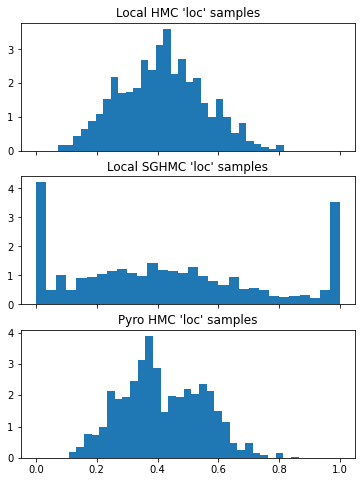

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
with torch.no_grad():
    axs[0].hist(samples_local["fairness"].numpy(), density=True, bins=30)
    axs[0].set(title="Local HMC 'loc' samples")
    axs[1].hist(sg_samples_local["fairness"].numpy(), density=True, bins=30)
    axs[1].set(title="Local SGHMC 'loc' samples")
    axs[2].hist(samples_pyro["fairness"].numpy(), density=True, bins=30)
    axs[2].set(title="Pyro HMC 'loc' samples")
plt.show()
#posterior samples should look like a beta(5, 7) dist